In [5]:
import os
import random
import numpy as np
import pylab as plt
%matplotlib inline

import sys
# sys.path.insert(0,'./../../../alan/CSGAN/')

import csgan as cs


In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../dataset/mnist/")

Extracting ../../../dataset/mnist/train-images-idx3-ubyte.gz
Extracting ../../../dataset/mnist/train-labels-idx1-ubyte.gz
Extracting ../../../dataset/mnist/t10k-images-idx3-ubyte.gz
Extracting ../../../dataset/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
x_train = mnist.train.images[:55000,:]
x_train.shape

class data_provider(object):
    def __init__(self,x_train):
        
        x_train = x_train/np.max(x_train,axis=1)[:,None]
        self.x_train = x_train
        self.num = x_train.shape[0]
        
    def __call__(self,n):
        n_list = np.arange(self.num)
        random.shuffle(n_list)
        return self.x_train[n_list[:n]].reshape(n,28,28,1)
        

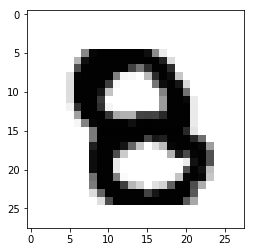

In [8]:
dp = data_provider(x_train)
    
image = dp(10)[0].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [9]:
dp(10).shape

(10, 28, 28, 1)

In [10]:
# defult_model_build lets you to define your own generator and discriminator. 
# Set it to 1, if you want to use default DCGAN architecture.
defult_model_build=0 

dcgan = cs.DCGAN(
    data_provider = dp,
    batch_size=64, gf_dim=64, df_dim=64,
    z_dim=100,checkpoint_dir='./checkpoint/',
    save_per = 100, defult_model_build=defult_model_build)

Output size is same as input's!


In [11]:
if ~defult_model_build:
    import tensorflow as tf

    def discriminator(image, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()

            trainable = 1

            h0 = tf.layers.conv2d(inputs=image, filters=dcgan.df_dim, kernel_size=[5,5], 
                     strides=(2,2),padding='same',
                     activation=tf.nn.relu, name='d_h0_conv')

            h1 = tf.layers.conv2d(inputs=h0, filters=2*dcgan.df_dim, kernel_size=[5,5], 
                     strides=(2,2),padding='same',
                     activation=None, name='d_h1_conv')
            h1 = tf.contrib.layers.batch_norm(h1,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='d_bn1')
            h1 = tf.nn.relu(h1)

            h2 = tf.layers.conv2d(inputs=h1, filters=4*dcgan.df_dim, kernel_size=[5,5], 
                     strides=(2,2),padding='same',
                     activation=None, name='d_h2_conv')
            h2 = tf.contrib.layers.batch_norm(h2,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='d_bn2')
            h2 = tf.nn.relu(h2)

            h3 = tf.layers.conv2d(inputs=h2, filters=8*dcgan.df_dim, kernel_size=[5,5], 
                     strides=(2,2),padding='same',
                     activation=None, name='d_h3_conv')
            h3 = tf.contrib.layers.batch_norm(h3,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='d_bn3')
            h3 = tf.nn.relu(h3)

            h4 = tf.layers.dense(inputs=tf.reshape(h3, [dcgan.batch_size, -1]),
                                 units=1,kernel_initializer=tf.random_normal_initializer(stddev=0.02), 
                                 bias_initializer=tf.constant_initializer (0.01),
                                 use_bias=1,activation=None,name='d_h4_lin')

        return tf.nn.sigmoid(h4), h4

    def generator(z, batch_size, mode='train'):
        with tf.variable_scope("generator") as scope:
            if mode=='train':
                trainable = True
                pass
            elif mode=='sampler':
                trainable = False
                scope.reuse_variables()
            else:
                assert 0,'Unkown mode for generator.'

            s_h, s_w = dcgan.output_height, dcgan.output_width
            s_h2, s_w2 = cs.conv_out_size_same(s_h, 2),  cs.conv_out_size_same(s_w, 2)
            s_h4, s_w4 = cs.conv_out_size_same(s_h2, 2),  cs.conv_out_size_same(s_w2, 2)
            s_h8, s_w8 = cs.conv_out_size_same(s_h4, 2),  cs.conv_out_size_same(s_w4, 2)
            s_h16, s_w16 = cs.conv_out_size_same(s_h8, 2),  cs.conv_out_size_same(s_w8, 2)

            # assert s_h16*s_w16*self.gf_dim*8==z.shape[1],str(s_h16*s_w16*self.gf_dim*8)+' != '+str(z.shape[1])

            # project `z` and reshape
            dcgan.z_ = tf.layers.dense(z,dcgan.gf_dim * 8 * s_h16 * s_w16,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.02), 
                                bias_initializer=tf.constant_initializer (0.01),
                                use_bias=1,activation=None,name='g_h0_lin')
            with tf.variable_scope('g_h0_lin', reuse=True):
                dcgan.h0_w = tf.get_variable('kernel')
                dcgan.h0_b = tf.get_variable('bias')
            dcgan.h0 = tf.reshape(dcgan.z_, [batch_size, s_h16, s_w16, dcgan.gf_dim * 8])
            h0 = tf.contrib.layers.batch_norm(dcgan.h0,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='g_bn0')
            h0 = tf.nn.relu(h0)

            dcgan.h1, dcgan.h1_w, dcgan.h1_b = cs.deconv2d(h0, [batch_size, s_h8, s_w8, dcgan.gf_dim * 4], 
                                                    name='g_h1', with_w=True)
            h1 = tf.contrib.layers.batch_norm(dcgan.h1,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='g_bn1')
            h1 = tf.nn.relu(h1) 

            h2, dcgan.h2_w, dcgan.h2_b = cs.deconv2d(h1, [batch_size, s_h4, s_w4, dcgan.gf_dim * 2],
                                                     name='g_h2', with_w=True)
            h2 = tf.contrib.layers.batch_norm(h2,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='g_bn2')
            h2 = tf.nn.relu(h2) 

            h3, dcgan.h3_w, dcgan.h3_b = cs.deconv2d(h2, [batch_size, s_h2, s_w2, dcgan.gf_dim * 1],
                                                     name='g_h3', with_w=True)
            h3 = tf.contrib.layers.batch_norm(h3,decay=0.9,updates_collections=None,
                            epsilon=1e-5,scale=True,is_training=trainable,scope='g_bn3')
            h3 = tf.nn.relu(h3) 

            h4, dcgan.h4_w, dcgan.h4_b = cs.deconv2d(h3, [batch_size, s_h, s_w, dcgan.c_dim],
                                                     name='g_h4', with_w=True)

            return tf.nn.tanh(h4)
        
    dcgan.discriminator = discriminator
    dcgan.generator = generator
    dcgan.build_model()

In [12]:
dcgan.train(num_epoch=4,batch_per_epoch = 200,verbose=10)

In [13]:
# dcgan.generate(np.random.normal(0,1,100))

In [ ]:
dcgan.train(num_epoch=2,batch_per_epoch = 3,verbose=10,sample_per=1)

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
./samples/train_00_0000.png
./samples/train_00_0001.png
